In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset (replace 'input_file.csv' with your actual file path)
input_file = 'Book5csv.csv'
df = pd.read_csv(input_file)

# Display the original dataset
#print("Original DataFrame:")
#print(df.head())

# Define the columns
date_column = 'Date'
columns_to_one_hot_encode = ['Time Quarter', 'probe_asn (probe_network_name)', 'resolver_asn (resolver_ip)', 'resolver_network_name']

# Standard Scaling for the Date column
scaler = StandardScaler()
df[date_column] = scaler.fit_transform(df[[date_column]])

# Perform one-hot encoding for the other selected columns
encoded_columns = pd.get_dummies(df[columns_to_one_hot_encode], drop_first=False)

# Combine the first column, scaled Date, encoded columns, and last column
first_column = df.iloc[:, 0]  # First column (Input_Probe)
last_column = df.iloc[:, -1]  # Last column (blocking_type)
df_encoded = pd.concat([first_column, df[date_column], encoded_columns, last_column], axis=1)

# Save the processed dataset
output_file = 'encoded_dataset.csv'
df_encoded.to_csv(output_file, index=False)

# Display the processed DataFrame
#print("\nProcessed DataFrame:")
#print(df_encoded.head())


Label Encoding

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add the PCA-transformed components and cluster labels to a new DataFrame for plotting
df_clusters = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_clusters['Cluster'] = y_pred_mapped
df_clusters['True Label'] = y_true_encoded

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_clusters['PCA1'], df_clusters['PCA2'], c=df_clusters['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('Cluster Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Plot true labels for comparison (optional)
plt.figure(figsize=(10, 8))
scatter_true = plt.scatter(df_clusters['PCA1'], df_clusters['PCA2'], c=df_clusters['True Label'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter_true, label='True Label')
plt.title('True Labels Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


test with 3 classes


Encoded Class Labels:
[0 0 1 ... 0 0 1]

Accuracy: 0.604


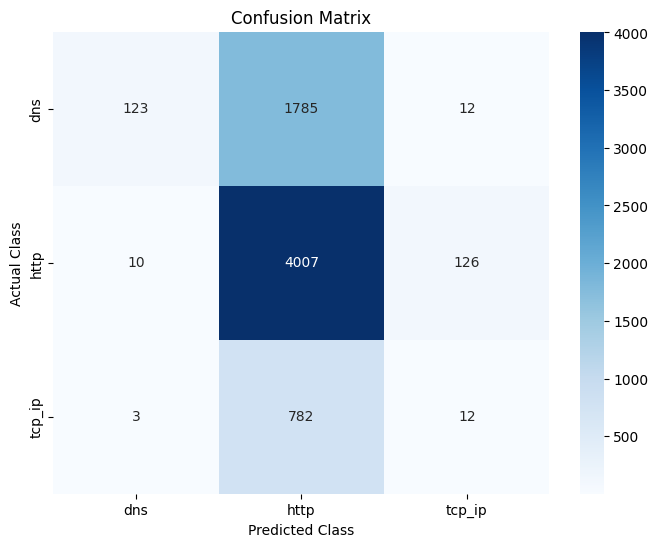


Classification Report:
              precision    recall  f1-score   support

         dns       0.90      0.06      0.12      1920
        http       0.61      0.97      0.75      4143
      tcp_ip       0.08      0.02      0.03       797

    accuracy                           0.60      6860
   macro avg       0.53      0.35      0.30      6860
weighted avg       0.63      0.60      0.49      6860


Clustered DataFrame with Predictions:
                              input(url)  Date  Time Quarter_Q1  \
0                   http://www.weedy.be/   0.0             True   
3    http://xn--80aaifmgl1achx.xn--p1ai/   0.0             True   
10  https://www.facebook.com/atrchannel/   0.0             True   
14            https://www.instagram.com/   0.0             True   
31                  https://twitter.com/   0.0             True   

    Time Quarter_Q2  Time Quarter_Q3  \
0             False            False   
3             False            False   
10            False            Fa

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# Load the encoded dataset (replace 'encoded_dataset.csv' with your actual file path)
input_file = 'encoded_dataset.csv'
df_encoded = pd.read_csv(input_file)
#print("Original DataFrame Preview:")
#print(df_encoded.head())

# Preprocess the data by removing rows where the class is 'false'
df_encoded = df_encoded[df_encoded['blocking_type'].str.lower() != 'false']
#print("\nData After Removing 'false':")
#print(df_encoded.head())

# Exclude the first column (Input_Probe) and the last column (class labels) for clustering
X = df_encoded.iloc[:, 1:-1]  # Exclude Input_Probe and blocking_type
y_true = df_encoded['blocking_type']  # Actual class labels

# Scale the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # 3 clusters for dns, tcp, http
y_pred = kmeans.fit_predict(X_scaled)

# Encode the class labels as integers for comparison
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
print("\nEncoded Class Labels:")
print(y_true_encoded)

# Create a confusion matrix without mapping
confusion_mat = confusion_matrix(y_true_encoded, y_pred)

# Use Hungarian algorithm to find the best cluster-to-class mapping
row_ind, col_ind = linear_sum_assignment(-confusion_mat)
mapping = {col: row for col, row in zip(col_ind, row_ind)}

# Map the predicted labels to the actual classes
y_pred_mapped = [mapping[label] for label in y_pred]

# Compute the confusion matrix after mapping
confusion_mat_mapped = confusion_matrix(y_true_encoded, y_pred_mapped)

# Calculate the accuracy
accuracy = sum(confusion_mat_mapped.diagonal()) / confusion_mat_mapped.sum()
print(f"\nAccuracy: {accuracy:.3f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_mapped, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true_encoded, y_pred_mapped, target_names=label_encoder.classes_))

# Save the dataset with cluster assignments
df_encoded['predicted_cluster'] = y_pred_mapped
output_file = 'clustered_dataset_with_predictions.csv'
df_encoded.to_csv(output_file, index=False)

# Print a preview of the clustered DataFrame
print("\nClustered DataFrame with Predictions:")
print(df_encoded.head())


dbscan

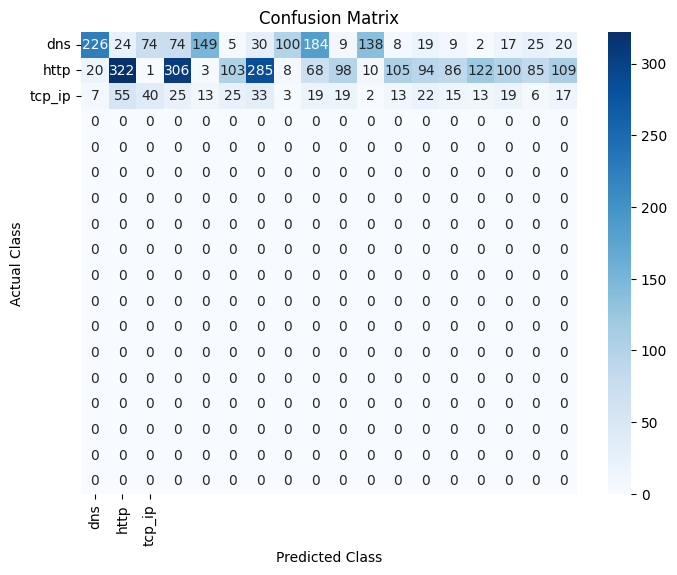


Classification Report:
              precision    recall  f1-score   support

         dns       0.89      0.20      0.33      1113
        http       0.80      0.17      0.28      1925
      tcp_ip       0.35      0.12      0.17       346

   micro avg       0.76      0.17      0.28      3384
   macro avg       0.68      0.16      0.26      3384
weighted avg       0.79      0.17      0.28      3384


Accuracy: 0.174

Clustered DataFrame with Predictions:


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment

# Load the dataset (replace 'encoded_dataset.csv' with your actual file path)
input_file = 'encoded_dataset.csv'
df_encoded = pd.read_csv(input_file)
#print("Original DataFrame Preview:")
#print(df_encoded.head())

# Preprocess the data: Remove rows with class label 'false'
df_encoded = df_encoded[df_encoded['blocking_type'].str.lower() != 'false']
#print("\nData After Removing 'false':")
#print(df_encoded.head())

# Exclude the first column (Input_Probe) and the last column (class labels) for clustering
X = df_encoded.iloc[:, 1:-1]  # Exclude Input_Probe and blocking_type
y_true = df_encoded['blocking_type']  # Actual class labels

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=100)  # Adjust `eps` and `min_samples` as needed
y_pred = dbscan.fit_predict(X_scaled)

# Map cluster labels to actual class labels
# Filter out noise points labeled as -1
valid_indices = y_pred != -1
X_valid = X_scaled[valid_indices]
y_pred_valid = y_pred[valid_indices]
y_true_valid = y_true.iloc[valid_indices]

# Encode true labels for comparison
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true_valid)

# Map DBSCAN labels to classes using Hungarian algorithm
confusion_mat = confusion_matrix(y_true_encoded, y_pred_valid, labels=sorted(set(y_pred_valid)))
row_ind, col_ind = linear_sum_assignment(-confusion_mat)
mapping = {col: row for col, row in zip(col_ind, row_ind)}

# Remap predicted labels
y_pred_mapped = [mapping[label] if label in mapping else -1 for label in y_pred_valid]

# Compute confusion matrix and accuracy
confusion_mat_mapped = confusion_matrix(y_true_encoded, y_pred_mapped)
accuracy = sum(confusion_mat_mapped.diagonal()) / confusion_mat_mapped.sum()

# Print the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_mapped, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

# Handle mismatch in labels
valid_labels = sorted(set(y_true_encoded) & set(y_pred_mapped))  # Intersection of valid labels
valid_target_names = [label_encoder.inverse_transform([label])[0] for label in valid_labels]

# Compute and print the classification report
print("\nClassification Report:")
print(classification_report(y_true_encoded, y_pred_mapped, labels=valid_labels, target_names=valid_target_names))

# Print the overall accuracy
print(f"\nAccuracy: {accuracy:.3f}")

# Add cluster assignments to the dataset
df_encoded['predicted_cluster'] = y_pred
df_encoded.loc[~valid_indices, 'predicted_cluster'] = -1  # Mark noise points explicitly

# Save the clustered dataset
output_file = 'dbscan_clustered_dataset_with_predictions.csv'
df_encoded.to_csv(output_file, index=False)

# Print a preview of the clustered DataFrame
print("\nClustered DataFrame with Predictions:")
#print(df_encoded.head())


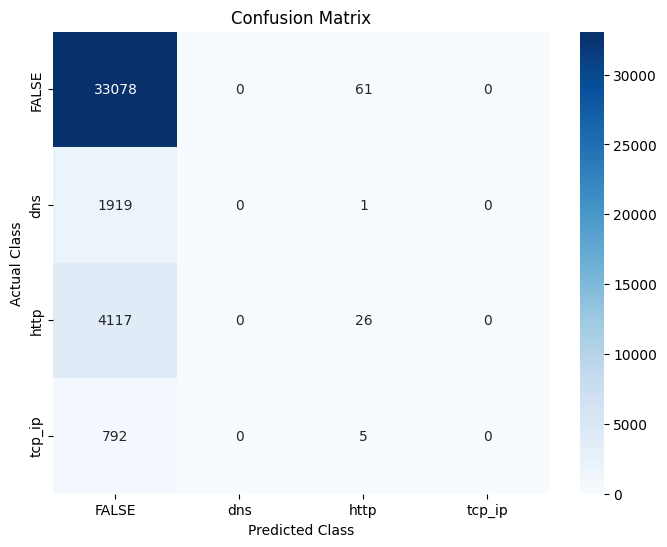


Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       FALSE       0.83      1.00      0.91     33139
         dns       0.00      0.00      0.00      1920
        http       0.28      0.01      0.01      4143
      tcp_ip       0.00      0.00      0.00       797

    accuracy                           0.83     39999
   macro avg       0.28      0.25      0.23     39999
weighted avg       0.72      0.83      0.75     39999



In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# Load the encoded dataset (replace 'encoded_dataset.csv' with your actual file path)
input_file = 'encoded_dataset.csv'
df_encoded = pd.read_csv(input_file)
#print(df_encoded.head())

# Exclude the first column (Input_Probe) and the last column (class labels) for clustering
X = df_encoded.iloc[:, 1:-1]  # Exclude Input_Probe and blocking_type
y_true = df_encoded['blocking_type']  # Actual class labels

# Scale the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
y_pred = kmeans.fit_predict(X_scaled)

# Map cluster labels to class labels using the Hungarian algorithm
from sklearn.preprocessing import LabelEncoder

# Encode the class labels as integers for comparison
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
#print(y_true_encoded)

# Create a confusion matrix without mapping
confusion_mat = confusion_matrix(y_true_encoded, y_pred)

# Use Hungarian algorithm to find the best cluster-to-class mapping
row_ind, col_ind = linear_sum_assignment(-confusion_mat)
mapping = {col: row for col, row in zip(col_ind, row_ind)}

# Map the predicted labels to the actual classes
y_pred_mapped = [mapping[label] for label in y_pred]

# Compute the confusion matrix after mapping
confusion_mat_mapped = confusion_matrix(y_true_encoded, y_pred_mapped)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat_mapped, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true_encoded, y_pred_mapped, target_names=label_encoder.classes_))

# Save the dataset with cluster assignments
df_encoded['predicted_cluster'] = y_pred_mapped
output_file = 'clustered_dataset_with_predictions.csv'
df_encoded.to_csv(output_file, index=False)

# Print a preview of the clustered DataFrame
#print("\nClustered DataFrame with Predictions:")
#print(df_encoded.head())